# Import Libraries

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 24.7 MB/s 
     |████████████████████████████████| 7.6 MB 60.3 MB/s 
     |████████████████████████████████| 182 kB 80.6 MB/s 


In [4]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 20.8 MB/s 
     |████████████████████████████████| 212 kB 45.1 MB/s 
     |████████████████████████████████| 132 kB 78.4 MB/s 
     |████████████████████████████████| 127 kB 63.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric

# Import Dataset

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/nzlul03/NLP-python-playground/main/text_classification/Indo-BERT/clean.csv')
df.head()

,text_clean,polarity
0,good morning semangat kerja hari moga kasih re...,positive
1,alhamdulillah minggu padat giat hari bimbing j...,positive
2,good morning terima kasih allah friday siap ku...,positive
3,selamat pagi dunia selamat pagi mutual selamat...,positive
4,syukur kuliah syukur fasilitas mumpuni support...,positive


## Preprocessing Dataset

In [7]:
df.rename(columns={'text_clean':'text',
                   'polarity': 'label'},
          inplace=True)

df.replace("", float("NaN"),
           inplace=True)

df.dropna(inplace=True)
df.sample(5)

,text,label
4908,ganggu terus hambat kuliah onlen,negative
4829,bangeettt kuliah onlen naik punggung terus tid...,negative
2722,nyata tujuh bulan kuliah onlen laptop lelah pr...,negative
5507,ada semangat kuliah onlen,neutral
6223,shshshs kangen sama kuliah onlen gaseru,neutral


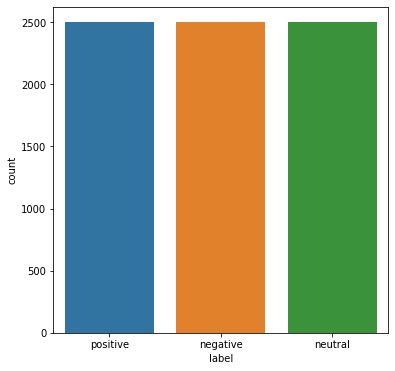

In [8]:
plt.figure(figsize=(6,6))
sns.countplot(x=df['label'])
plt.show()

In [9]:
df['label'] = df['label'].map({'negative': 0,
                               'neutral': 1,
                               'positive': 2})

## Train Test Split

In [10]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED
)

In [12]:
df_train.shape

(6000, 2)

In [14]:
df_val.shape

(1350, 2)

In [15]:
df_test.shape

(150, 2)

In [17]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [18]:
from datasets import load_dataset

files = {
    "train": "train.csv", 
    "eval": "eval.csv", 
    "test": "test.csv",
}

dataset = load_dataset('csv', data_files=files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4e347c1468ee3fb8/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Tokenize Model

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

# Train Model

In [23]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [24]:
model = AutoModelForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2',
                                                           num_labels=3)

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=4,
)

In [26]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

<ipython-input-26-fd3739473b36>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4500
  Number of trainable parameters = 124443651
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Step,Training Loss
500,0.779400
1000,0.651500
1500,0.597900
2000,0.421200
2500,0.387000
3000,0.381100
3500,0.230200
4000,0.256200
4500,0.223100


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2500
Configuration saved in test_trainer/checkpoint-2500/config.json
Model weights saved in test_trainer/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-30

# Evaluate the Model

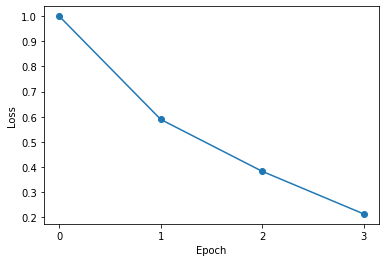

In [27]:
plt.plot([1, 0.5891, 0.3825, 0.2129], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3])
plt.show()

In [28]:
evaluation_history = trainer.evaluate()
evaluation_history

***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 0.4759141206741333,
 'eval_accuracy': 0.9088888888888889,
 'eval_runtime': 20.0552,
 'eval_samples_per_second': 67.314,
 'eval_steps_per_second': 8.427,
 'epoch': 3.0}

In [29]:
test_dataset = tokenized_datasets['test']

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

***** Running Prediction *****
  Num examples = 150
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


In [30]:
print(classification_report(prediction,
                            df_test['label'],
                            target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.89      0.93      0.91        44
      Netral       0.82      0.76      0.79        49
     Positif       0.85      0.88      0.86        57

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150



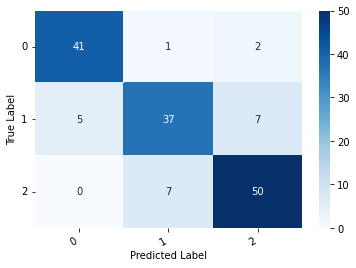

In [31]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, df_test['label'])
show_confusion_matrix(cm)

# Save and Load Model

In [32]:
model.save_pretrained("model")

Configuration saved in model/config.json
Model weights saved in model/pytorch_model.bin


In [33]:
model = AutoModelForSequenceClassification.from_pretrained("model")

loading configuration file model/config.json
Model config BertConfig {
  "_name_or_path": "model",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classificatio

In [35]:
trainer = Trainer(model=model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    label = trainer.predict([tokenized]).predictions.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Negatif [{label}]')
    elif label == 1:
        print(f'Predicted: Netral [{label}]')
    else:
        print(f'Predicted: Positif [{label}]')

In [39]:
predict("""universitas ini mahal banget bayar uktnya fasilitasnya juga jelek""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Negatif [0]
